Before moving to the code, we will study about a brief overview of CNN: 

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

Convolutional neural networks (or ConvNets) are a very succesfull type of neural networks, and are an integral part of reigniting the interest in neural networks. They are abel to extract structural relations in the data such as spatial in images or temporal in time series.

Jason Yosinski and colleague developed a toolbox for visualizing convolutional networks. Unfortunately this toolbox is for Caffe, so we can't use it here, but they made a VERY instructive video that does a great job of conveying the intuitions.

In this lab you will learn what convolutional layers are and how they work, as well as important related concepts such as padding, stride, and pooling.

External resources:
For an indept tutorial please see stanford cs231n or to read more see Michael Nielsen.


for indepth tutorial please refer to https://cs231n.github.io/convolutional-networks/#overview


# What are convolutional networks?
ConvNets are in may respects very similar to the dense feedforward networks

* The network is still organized into layers
* Each layer is parameterized by weights and biases
* Each layer has an element-wise non-linear transformation (activation function)
* There are no cycles in the connections (more on this in later labs)

So what is the difference? The networks we saw previously are called dense because each unit receives input from all the units in the previous layer. This is not the case for ConvNets. In ConvNets each unit is only connected to a small subset of the input units. This is called the receptive field of the unit.

### Let us look at a quick example.
Let us define a 3x3 window with the kernel weights (indicated by red in the bottom right). We apply the window by performning elementwise multiplication, and then summing the results, as shown in this animation:

![../figures/convolutions.gif](/Users/mrinal18/Desktop/Research/Deep_Learning_Catalyst/figures/convolutions.gif)

After convoluting the images, we go element wise "non-linear" transformation on the convolved figures. In this example input is a 2D feature map with depth 1.


### Strides, padding, and pooling

Two important concepts for ConvNets are strides and padding.

### Padding
Padding describes what we do at the edges of the feature map. If we don't use padding the feature map will get smaller every time, as we can see above. If we do use padding we can maintain the same resolution. In deep learning we generally just pad with zeros. In the example below in the 'Padding, no strides' GIF we maintain the size by padding with one row/column of zeros on all sides.

Strides
describe how far the window is moved each time. Strides can be used to reduce the size of the feature map, and the number of computations that needs to be performed.

Strides and pooling (exerpted from [here](https://github.com/vdumoulin/conv_arithmetic#convolution-animations)) are shown in the table below. Notice how the output (green) changes shape.

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="figures/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="figures/gif/arbitrary_padding_no_strides.gif"></td>
    <td><img width="150px" src="figures/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="figures/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="figures/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="figures/gif/padding_strides.gif"></td>
    <td><img width="150px" src="figures/gif/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>


### Pooling
is another method for reducing the spatial resolution. Similar to convolutional layers it works by sliding a window accross the feature map. Unlike the convolutional layers there are no learnable parameters, and the pooling layers perform the same simple operation every time. The most common types of pooling are:

Max pooling where the output of the pooling operation is the highest value in the window, and
Mean pooling which outputs the mean of the elements in the window.

![pooling](/Users/mrinal18/Desktop/Research/Deep_Learning_Catalyst/figures/pooling.png)

In [1]:
! pip install -U torch==1.8.0 torchvision==0.9.0 catalyst==21.04.2 albumentations==0.5.0

     |████████████████████████████████| 119.6 MB 47.3 MB/s            
     |████████████████████████████████| 13.2 MB 19.7 MB/s            
     |████████████████████████████████| 511 kB 111.3 MB/s            
     |████████████████████████████████| 70 kB 18.3 MB/s            
     |████████████████████████████████| 948 kB 90.7 MB/s            
     |████████████████████████████████| 45.5 MB 730 kB/s             
     |████████████████████████████████| 1.2 MB 106.5 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
  Attempting uninstall: catalyst
    Found existing installation: catalyst 21.10
    Uninstalling catalyst-21.10:
      Successfully uninstalled catalyst-21.10
You should consider upgrading

Source taken from [here](https://colab.research.google.com/github/catalyst-team/dl-course/blob/master/week-03/seminar.ipynb)

In [2]:
from catalyst import dl, metrics, utils


utils.set_global_seed(42)
device = utils.get_device()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [5]:
!wget http://placekitten.com/200/300 -O cat.jpg 

--2021-11-03 12:45:26--  http://placekitten.com/200/300
Resolving placekitten.com (placekitten.com)... 2606:4700:3035::ac43:b450, 2606:4700:3030::6815:3042, 172.67.180.80, ...
Connecting to placekitten.com (placekitten.com)|2606:4700:3035::ac43:b450|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7191 (7.0K)
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   7.02K  --.-KB/s    in 0s      

2021-11-03 12:45:26 (31.6 MB/s) - ‘cat.jpg’ saved [7191/7191]



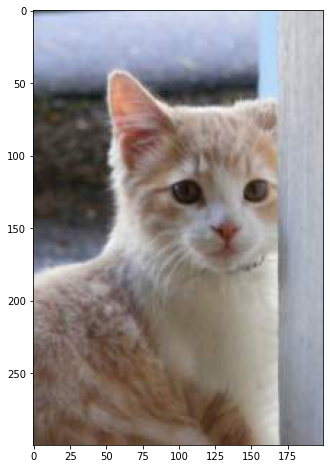

In [6]:
from PIL import Image

image = Image.open("cat.jpg")
fig, ax = plt.subplots(figsize=(18, 8))
ax.imshow(image)

We will use ResNet and AlexNet demonstration. 

It has big kernels in the begging, and they compute easy-to-understand feature pics.


In [16]:
model_res_net = models.resnet18(pretrained=True)
print(
    "\n".join(
        f"Name: {n}, module:{m}"
        for n, m in list(model_res_net.named_children())
    )
)

model_alexnet = models.alexnet(pretrained=True)
print(
    "\n".join(
        f"Name: {n}, module:{m}"
        for n, m in list(model_alexnet.features.named_modules())[1:]
    )
)

Name: conv1, module:Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Name: bn1, module:BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Name: relu, module:ReLU(inplace=True)
Name: maxpool, module:MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Name: layer1, module:Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(i

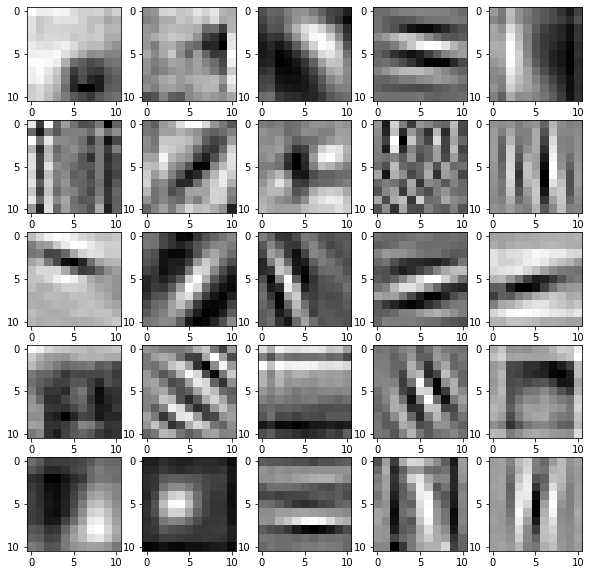

In [25]:
_, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    w = model_alexnet.features[0].weight[i].detach().numpy()[0]
    w = (w - w.min()) / (w.max() - w.min())
    ax[i // 5, i % 5].imshow(w, cmap="gray")

In [26]:
from scipy import signal


def convolute(w):
    """
    Quick written function for showing convolution results
    """
    new_image = signal.convolve2d(np.array(image)[:,:,0], w)
    _, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(np.array(image), cmap='gray')
    ax[2].imshow(new_image, cmap='gray')
    ax[1].imshow(w, cmap='gray')

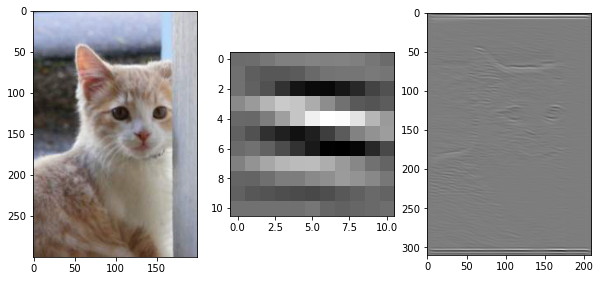

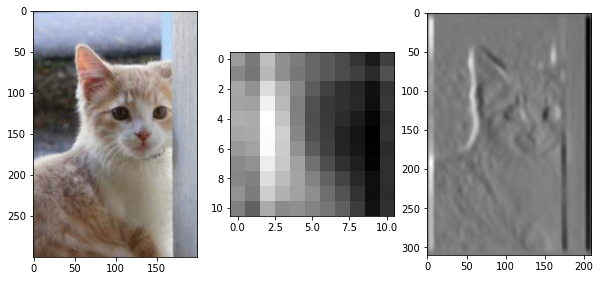

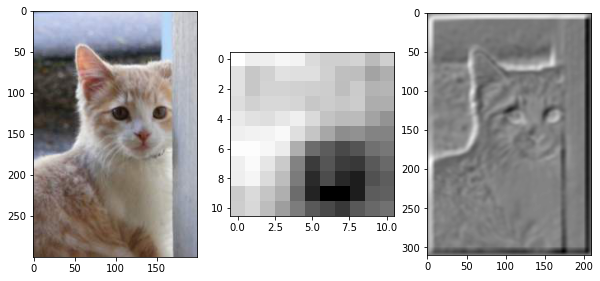

In [30]:
convolute(model_alexnet.features[0].weight[3].detach().numpy()[0])
convolute(model_alexnet.features[0].weight[4].detach().numpy()[0])
convolute(model_alexnet.features[0].weight[0].detach().numpy()[0])

In [58]:
import os
from torch import nn, optim
from torch.utils.data import DataLoader
from catalyst import dl
from catalyst.data import ToTensor
from catalyst.contrib.datasets import MNIST

model = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

train_data = MNIST(os.getcwd(), train=True, download=True, transform=ToTensor())
valid_data = MNIST(os.getcwd(), train=False, download=True, transform=ToTensor())

We will first look at an extensive implementation and then go to an easy way

In [64]:
import os


import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
import torchvision.models as models
import torchvision.transforms as transforms

from catalyst import dl, metrics, utils
from catalyst.data.transforms import ToTensor
from catalyst.contrib.datasets import MNIST

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


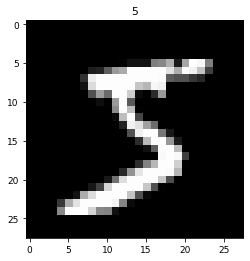

In [59]:
print(train_data.classes)
plt.imshow(train_data[0][0].numpy().reshape(28, 28), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [60]:
loaders = {
    "train": DataLoader(train_data, batch_size=32),
    "valid": DataLoader(valid_data, batch_size=32),
}


Let's do this using a very convinient way!!

In [63]:

runner = dl.SupervisedRunner()
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=1,
    logdir="./logs",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
# uncomment for extra metrics:
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", num_classes=10),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
        dl.AUCCallback(input_key="logits", target_key="targets"),
        # catalyst[ml] required ``pip install catalyst[ml]``
        dl.ConfusionMatrixCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
    ]
)


1/1 * Epoch (train): 100%|██████████| 1875/1875 [00:31<00:00, 59.31it/s, accuracy=0.938, accuracy01=0.938, accuracy03=1.000, accuracy05=1.000, f1/_macro=0.923, f1/_micro=0.937, f1/_weighted=0.940, f1/class_00=1.000, f1/class_01=1.000, f1/class_02=0.909, f1/class_03=0.857, f1/class_04=0.667, f1/class_05=1.000, f1/class_06=1.000, f1/class_07=1.000, f1/class_08=0.800, f1/class_09=1.000, loss=0.093, lr=0.020, momentum=0.900, precision/_macro=0.925, precision/_micro=0.938, precision/_weighted=0.961, precision/class_00=1.000, precision/class_01=1.000, precision/class_02=1.000, precision/class_03=0.750, precision/class_04=0.500, precision/class_05=1.000, precision/class_06=1.000, precision/class_07=1.000, precision/class_08=1.000, precision/class_09=1.000, recall/_macro=0.950, recall/_micro=0.938, recall/_weighted=0.937, recall/class_00=1.000, recall/class_01=1.000, recall/class_02=0.833, recall/class_03=1.000, recall/class_04=1.000, recall/class_05=1.000, recall/class_06=1.000, recall/class_

train (1/1) accuracy: 0.8801000118255615 | accuracy/std: 0.07139321828105896 | accuracy01: 0.8801000118255615 | accuracy01/std: 0.07139321828105896 | accuracy03: 0.9750000238418579 | accuracy03/std: 0.03628620414808998 | accuracy05: 0.9921000003814697 | accuracy05/std: 0.02198707325960369 | auc: 0.9688791036605835 | auc/_macro: 0.9688791036605835 | auc/_micro: 0.9739116825617284 | auc/_weighted: 0.9695435762405396 | auc/class_00: 0.9921244382858276 | auc/class_01: 0.995437741279602 | auc/class_02: 0.962507963180542 | auc/class_03: 0.9620566368103027 | auc/class_04: 0.982339084148407 | auc/class_05: 0.9447546601295471 | auc/class_06: 0.9885842800140381 | auc/class_07: 0.9869846701622009 | auc/class_08: 0.9249991178512573 | auc/class_09: 0.9490035176277161 | f1/_macro: 0.8784880637311161 | f1/_micro: 0.8800950000284057 | f1/_weighted: 0.8799977356479897 | f1/class_00: 0.9396385777881021 | f1/class_01: 0.9488678453912809 | f1/class_02: 0.8672651128633844 | f1/class_03: 0.8546846721565908 

1/1 * Epoch (valid): 100%|██████████| 313/313 [00:05<00:00, 55.85it/s, accuracy=0.875, accuracy01=0.875, accuracy03=0.938, accuracy05=1.000, f1/_macro=0.830, f1/_micro=0.875, f1/_weighted=0.850, f1/class_00=1.000, f1/class_01=0.800, f1/class_02=1.000, f1/class_03=0.500, f1/class_04=1.000, f1/class_05=1.000, f1/class_06=1.000, f1/class_07=1.000, f1/class_08=0.000e+00, f1/class_09=1.000, loss=0.607, lr=0.020, momentum=0.900, precision/_macro=0.817, precision/_micro=0.875, precision/_weighted=0.833, precision/class_00=1.000, precision/class_01=0.667, precision/class_02=1.000, precision/class_03=0.500, precision/class_04=1.000, precision/class_05=1.000, precision/class_06=1.000, precision/class_07=1.000, precision/class_08=0.000e+00, precision/class_09=1.000, recall/_macro=0.850, recall/_micro=0.875, recall/_weighted=0.875, recall/class_00=1.000, recall/class_01=1.000, recall/class_02=1.000, recall/class_03=0.500, recall/class_04=1.000, recall/class_05=1.000, recall/class_06=1.000, recall/

valid (1/1) accuracy: 0.8500000238418579 | accuracy/std: 0.08422861417561484 | accuracy01: 0.8500000238418579 | accuracy01/std: 0.08422861417561484 | accuracy03: 0.9578999876976013 | accuracy03/std: 0.043333333333333376 | accuracy05: 0.9886999726295471 | accuracy05/std: 0.019697050474112576 | auc: 0.969152569770813 | auc/_macro: 0.969152569770813 | auc/_micro: 0.9685465699999998 | auc/_weighted: 0.9697654843330383 | auc/class_00: 0.9976166486740112 | auc/class_01: 0.9951648712158203 | auc/class_02: 0.9740883111953735 | auc/class_03: 0.9564452171325684 | auc/class_04: 0.9890890121459961 | auc/class_05: 0.9497079849243164 | auc/class_06: 0.9940884709358215 | auc/class_07: 0.9839494228363037 | auc/class_08: 0.8882690668106079 | auc/class_09: 0.9631059169769287 | f1/_macro: 0.8392634925666892 | f1/_micro: 0.8499950000294115 | f1/_weighted: 0.8419343626988577 | f1/class_00: 0.9621907546492889 | f1/class_01: 0.91210519856753 | f1/class_02: 0.8711782073009865 | f1/class_03: 0.8248240569717796

In the previous lesson you saw how to use a CNN to make your recognition of the handwriting digits more efficient. In this lesson you'll take that to the next level, recognizing real images of Cats and Dogs in order to classify an incoming image as one or the other. In particular the handwriting recognition made your life a little easier by having all the images be the same size and shape, and they were all monochrome color. Real-world images aren't like that -- they're in different shapes, aspect ratios etc, and they're usually in color!

So, as part of the task you need to process your data -- not least resizing it to be uniform in shape. 

You'll follow these steps:

1.   Explore the Example Data of Cats and Dogs
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy

In [ ]:
"""
1. Implement a classification of cats and dogs using catalyst without any arguments.
2. extract dataset from https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import catalyst
from catalyst.dl import SupervisedRunner

# 1. prepare data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.ImageFolder('../data/cat_dog/train', transform=transform)
valid_data = datasets.ImageFolder('../data/cat_dog/valid', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)

loaders = {"train": train_loader, "valid": valid_loader}

# 2. prepare model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

# 3. prepare optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. prepare callbacks
callbacks = [AccuracyCallback(num_classes=2, accuracy_args=[1])]

# 5. train model
runner = SupervisedRunner()
runner.train(
    model=model,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    logdir="./logs",
    num_epochs=10,
    verbose=True
)

## plotting convolutional weights

In [ ]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
plot_conv_weights(weights=weights_conv2)

Homework:
These are a few suggestions for exercises that may help improve your skills with Catalyst. It is important to get hands-on experience with Catalyst in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

Do you get the exact same results if you run the Notebook multiple times without changing any parameters? What are the sources of randomness?
1. Run another 10,000 optimization iterations. Are the results better?
2. Change the learning-rate for the optimizer.
3. Change the configuration of the layers, such as the number of convolutional filters, the size of those filters, the number of neurons in the fully-connected layer, etc.
4. Add a so-called drop-out layer after the fully-connected layer. Note that the drop-out probability should be zero when calculating the classification accuracy, so you will need a placeholder variable for this probability.
5. Change the order of ReLU and max-pooling in the convolutional layer. Does it calculate the same thing? What is the fastest way of computing it? How many calculations are saved? Does it also work for Sigmoid-functions and average-pooling?
6. Add one or more convolutional and fully-connected layers. Does it help performance?
7. What is the smallest possible configuration that still gives good results?
8. Try using ReLU in the last fully-connected layer. Does the performance change? Why?
9. Try not using pooling in the convolutional layers. Does it change the classification accuracy and training time?
10. Try using a 2x2 stride in the convolution instead of max-pooling? What is the difference?
Remake the program yourself without looking too much at this source-code.
11. Explain to a friend how the program works.